This is a Python port of the C code provided by Matjaž Perc, Nina Gorišek Miksić, Mitja Slavinec and Andraž Stožer in their paper "Forecasting COVID-19", as accessed on April 20th 2020: https://doi.org/10.3389/fphy.2020.00127

Requirements: 
- Python 3
- Pandas
- Matplotlib

In [9]:
%matplotlib inline

import pandas as pd
from datetime import datetime
import math

In [2]:
# File containing cumulative sum of confirmed cases, one day per line (must not contain gaps)
filename = "data/slovenia.txt"
data = open(filename,"r").read().split("\n")
data = [int(x) for x in data]

# Date of first line of data
y = 2020
m = 3
d = 4
startdate = datetime(y,m,d)

In [3]:
# Number of days to calculate the maximum, minimum and average growth rate
lastxdays = 14

# change these values if considering different death rates or #days to get well or to die
deathrate = 0.04
daystoheal = 14
daystodie = 21

In [5]:
growrate = {}
growrate[0] = 0

date = list(pd.date_range(datetime(2020,1,1),datetime(2030,1,1)))

# find the index of the starting date and remember as n
n = date.index(startdate)

actuals = {}

for i in range(len(data)):
    if i>0:
        growrate[i] = (data[i]/data[i-1])-1.0

    healed = 0.0
    died = 0.0
    
    if (i-daystoheal)>=0:
        healed = data[i-daystoheal]*(1.0-deathrate)
    if (i-daystodie)>=0:
        died = data[i-daystodie]*deathrate
    
    actuals[date[i+n]] = (data[i]-healed-died, growrate[i])

In [6]:
mingrowrate = math.inf
maxgrowrate = 0.0
avggrowrate = 0.0

for i in range(len(data)-lastxdays,len(data)):
    avggrowrate += growrate[i]
    if growrate[i] < mingrowrate: 
        mingrowrate = growrate[i]

    if growrate[i] > maxgrowrate:
        maxgrowrate = growrate[i]

avggrowrate = avggrowrate / lastxdays
    
print("using last %ld days" % lastxdays)
print("minimal growth rate is %.4lf" % mingrowrate)
print("maximal growth rate is %.4lf" % maxgrowrate)
print("average growth rate is %.4lf" % avggrowrate)

using last 14 days
minimal growth rate is 0.0476
maximal growth rate is 0.1553
average growth rate is 0.0902


In [7]:
maxgrowrate = maxgrowrate * 1.2
decgrowrate = maxgrowrate / 30.0

# Forecasting for 30 different growth rates (runs)
runs = {}
for q in range(31):
    predict = data[-1]
    forecast = {}
    for i in range(len(data),len(data)+daystoheal):
        predict = predict * (1 + maxgrowrate - q*decgrowrate)
        healed = 0.0
        died = 0.0
        if (i-daystoheal) >= 0:
            healed = data[i-daystoheal]*(1-deathrate);
        if (i-daystodie) >= 0:
            died = data[i-daystodie]*deathrate;
        forecast[date[i+n]] = int(predict-healed-died)
    rate = maxgrowrate-q*decgrowrate
    runs[rate] = forecast

Text(0.5, 1.0, 'Forecasts based on Perc et al (2020) \n https://doi.org/10.3389/fphy.2020.00127')

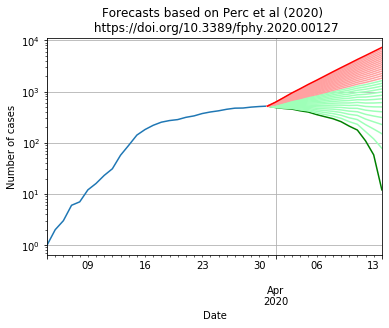

In [10]:
import matplotlib.pyplot as plt

actual = pd.DataFrame(actuals).iloc[0]
actual.plot()

for rate in sorted(runs.keys()):
    s = pd.Series(runs[rate])
    
    # This is just to connect the actual and forecast lines
    s = actual.tail(1).append(s)

    # Some pretty colors
    if rate<avggrowrate:
        c = '#9effb8'
    if rate>=avggrowrate:
        c = '#ffa1a1'
    if rate == min(runs.keys()):
        c = 'green'
    if rate == max(runs.keys()):
        c = 'red'
    s.plot(color=c)

plt.yscale('log')
plt.grid()
plt.ylabel("Number of cases")
plt.xlabel("Date")
plt.title("Forecasts based on Perc et al (2020) \n https://doi.org/10.3389/fphy.2020.00127")